In [1]:
import FinanceDataReader as fdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def getCloseData(ticker, start, end=None):
    """
    종가 데이터
    ticker: 종목 번호
    start: 시작일
    end: 마지막 날짜
    return: 종목의 종가 데이터
    """
    return fdr.DataReader(ticker, start, end)['Close']

def getDayReturn(closeDataSet):
    """
    개별종목 일별 수익률
    closeDataSet: 종가 데이터
    return: 종가 데이터의 일별 수익률
    """
    return (closeDataSet / closeDataSet.shift(1)).fillna(1)

def getCumulativeReturn(closeDataSet=None):
    """
    개별종목 누적수익률 == 자산흐름
    closeDataSet: 종가 데이터
    return:종가데이터 누적수익률
    """
    return closeDataSet / closeDataSet.iloc[0]

def getPortfolioResult(closeDataSet, weight=None):
    """
    포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    # 개별종목 일별 수익률
    dayReturn = getDayReturn(closeDataSet)
    # 개별종목 누적 수익률
    cumulativeReturn = getCumulativeReturn(closeDataSet)
    # 자산별 비중. 기본값: 동일비중
    if not weight:
        weight = [1/len(closeDataSet.columns)] * len(closeDataSet.columns)
        
    # 포트폴리오 누적 수익률
    portfolioCumulativeReturn = (weight * cumulativeReturn).sum(axis=1)
    # 포트폴리오 일별 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1)
        
#     # 자산별 비중이 반영된 개별자산 누적 수익률
#     weightedCumulativeReturn = weight * cumulativeReturn
#     # 자산흐름 정규화: 시기별 각 자산 보유 비율
#     normalizedAssetFlow = weightedCumulativeReturn.divide(weightedCumulativeReturn.sum(axis=1), axis=0) # 각 행의 합으로 각 행을 나누기
#     # 자산별 비중이 반영된 개별자산 일별 수익률
#     weightedDayReturn = normalizedAssetFlow * dayReturn.shift(-1).fillna(0)
#     # 포트폴리오 일별 수익률 = 자산별 비중이 반영된 개별자산 일별 수익률의 합
#     portfolioDayReturn = weightedDayReturn.sum(axis=1).shift(1).fillna(1)
#     # 포트폴리오 누적 수익률
#     portfolioCumulativeReturn = portfolioDayReturn.cumprod()
# #     portfolioCumulativeReturn = weightedCumulativeReturn.sum(axis=1)
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getEvaluation(cumulativeReturn):
    """
    cagr, dd, mdd
    투자 성과 지표
    """
    # cagr
    cagr = cumulativeReturn.iloc[-1] ** (252/len(cumulativeReturn))
    # mdd
    dd = (cumulativeReturn.cummax() - cumulativeReturn) / cumulativeReturn.cummax() * 100
    mdd= dd.max()
    
    print(f"cagr: {cagr}\nmdd: {mdd}")

    return cagr, dd, mdd

def getRebalancingDate(closeDataSet, period="month"):
    """
    리밸런싱 일자 추출
    월별, 분기별, 연별
    """
    data = closeDataSet.copy()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    data['year'] = data.index.year
    data['month'] = data.index.month
    
    if period == "month":
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
        
    if period == "quarter":
        # 3 6 9 12월 말에 리밸런싱
        # np where 같은걸로 3, 6, 9, 12월 데이터만 가져오고
        # drop_duplicates keep last 하면 됌
        quarter = [3,6,9,12]
        data = data.loc[data['month'].isin(quarter)]
        rebalancingDate = data.drop_duplicates(['year', 'month'], keep="last").index
    
    if period == "year":
        rebalancingDate = data.drop_duplicates(['year'], keep="last").index
        
    return rebalancingDate

def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn

def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df, 평균모멘텀 스코어 df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore

### 장세 판단과 투자비중

- 모멘텀에 따른 투자비중 조절
- 모멘텀 비중에 따른 리밸런싱 코드

지난번 리밸런싱 기법을 활용한 결과를 살펴봤습니다.  
항상 동일비중으로 리밸런싱을 했기 때문에 (+채권가격 커플링) 21년 강세장에 그 상승 추세를 누리지 못한게 아쉬웠습니다.  
이번에는 장세에 따라 자산 비율에 가중치를 주는 방법을 배워보겠습니다.  
우리가 사용할 방법은 데이터를 활용해서 현재 가격이 과거에 비해 상승 추세에 있는지 판단하고.  
수치화해서 포트폴리오 비율로 활용하는 것입니다.  


그 수단으로는 모멘텀 개념을 사용할 것입니다.  
모멘텀은 여러 논문에서도 소개되었고, 이론적 배경이 탄탄한 개념입니다.  
투자 시장에서 모멘텀이란,

$$모멘텀 = \frac{당기 주가}{전기 주가} $$

이렇게 계산할 수 있습니다. 수익률 공식과 같습니다.  
저렇게 간단하게 계산할 수 있는 모멘텀 지수를 활용해서 다양한 전략을 만들 수 있습니다.  

전통적으로는,


절대모멘텀,   n개월 모멘텀이 양수다. 하면 매수 또는 보유. 음수다. 하면 매도하는 전략입니다.  
상대모멘텀,   다양한 종목 중 매달 n개월 모멘텀을 계산해서 상위 몇개 자산에 분산투자 하는 전략입니다.  
듀얼모멘텀,   절대모멘텀, 상대모멘텀을 혼합하여 상대 모멘텀 전략으로 구한 상위 종목의 절대모멘텀을 기준으로 포트폴리오를 구성하는 전략입니다.  
(영상에 그림, 설명 추가)

그리고 수업에서는 평균모멘텀스코어라는 전략을 소개시켜드리겠습니다.  
퀀트계에서 유명한 systrader79님이 직접 개발하신 전략입니다.  
우리는 이 전략을 코드로 직접 구현하고 백테스트 해보겠습니다.

우선 평균모멘텀스코어 전략을 알아봅시다.  
투자에서 모멘텀은 수익률과 같은 개념입니다.  
n개월 절대 모멘텀 전략을 활용한다면 n을 몇으로 두느냐에 따라 그 결과가 달라지게 됩니다.(systrader79 그래프 참고)  
그렇다고 해서 가장 투자성과가 좋은 n이 최고다! 생각하는 것은 과최적화 오류를 범하는 것입니다.  
어떤 종목을 가지고 하느냐, 어떤 시점의 데이터를 가지고 하느냐에 따라 다 결과가 달라지기 때문이죠.  


이런 과최적화를 최소화할 수 있는 방법이 바로 평균모멘텀스코어입니다.  
평모스란, 모멘텀 > 1이라면, 1점을 부여하고. 모멘텀 <=1 이라면 0점을 부여해서 점수를 평균한 값입니다.  
그리고 이것을 해당 자산의 투자 비율로 사용할 것 입니다.  
만약 평모스가 높다면. 해당 자산은 지난 기간동안 계속 상승추세에 있다는 의미가 되는 것이고.  
낮다면 하락추세에 가깝다는 뜻이기에 장세에 맞춰서 투자 비중을 정할 수 있게 되는 것입니다.  

##### 모멘텀 구하는 방법

In [3]:
pd.set_option('display.max_row', None)

In [4]:
# 데이터 로드

kodex200 = getCloseData("069500", "2002")
kodex200

Date
2002-10-14     5412
2002-10-15     5545
2002-10-16     5569
2002-10-17     5646
2002-10-18     5886
2002-10-21     5726
2002-10-22     5601
2002-10-23     5767
2002-10-24     5745
2002-10-25     5767
2002-10-28     5975
2002-10-29     5936
2002-10-30     5796
2002-10-31     5767
2002-11-01     5692
2002-11-04     5921
2002-11-05     5852
2002-11-06     6027
2002-11-07     6027
2002-11-08     5936
2002-11-11     5788
2002-11-12     5783
2002-11-13     5745
2002-11-14     5753
2002-11-15     5936
2002-11-18     5875
2002-11-19     5921
2002-11-20     6058
2002-11-21     6134
2002-11-22     6153
2002-11-25     6264
2002-11-26     6223
2002-11-27     6277
2002-11-28     6340
2002-11-29     6428
2002-12-02     6470
2002-12-03     6531
2002-12-04     6336
2002-12-05     6399
2002-12-06     6361
2002-12-09     6264
2002-12-10     6223
2002-12-11     6176
2002-12-12     6264
2002-12-13     6270
2002-12-16     6106
2002-12-17     6253
2002-12-18     6292
2002-12-20     6319
2002-12-23     

In [5]:
kodex200.index.month

Int64Index([10, 10, 10, 10, 10, 10, 10, 10, 10, 10,
            ...
             6,  6,  6,  6,  6,  6,  6,  6,  6,  7],
           dtype='int64', name='Date', length=4877)

In [6]:
# 리밸런싱 일자
rebalancingDate = getRebalancingDate(kodex200)
rebalancingDate

DatetimeIndex(['2002-10-31', '2002-11-29', '2002-12-30', '2003-01-30',
               '2003-02-28', '2003-03-31', '2003-04-30', '2003-05-30',
               '2003-06-30', '2003-07-31',
               ...
               '2021-10-29', '2021-11-30', '2021-12-30', '2022-01-28',
               '2022-02-28', '2022-03-31', '2022-04-29', '2022-05-31',
               '2022-06-30', '2022-07-01'],
              dtype='datetime64[ns]', name='Date', length=238, freq=None)

In [7]:
# 투자 시작일 데이터만 순수하게 남기고
kodex200 = kodex200.loc[rebalancingDate[0]:]
kodex200

Date
2002-10-31     5767
2002-11-01     5692
2002-11-04     5921
2002-11-05     5852
2002-11-06     6027
2002-11-07     6027
2002-11-08     5936
2002-11-11     5788
2002-11-12     5783
2002-11-13     5745
2002-11-14     5753
2002-11-15     5936
2002-11-18     5875
2002-11-19     5921
2002-11-20     6058
2002-11-21     6134
2002-11-22     6153
2002-11-25     6264
2002-11-26     6223
2002-11-27     6277
2002-11-28     6340
2002-11-29     6428
2002-12-02     6470
2002-12-03     6531
2002-12-04     6336
2002-12-05     6399
2002-12-06     6361
2002-12-09     6264
2002-12-10     6223
2002-12-11     6176
2002-12-12     6264
2002-12-13     6270
2002-12-16     6106
2002-12-17     6253
2002-12-18     6292
2002-12-20     6319
2002-12-23     6162
2002-12-24     6019
2002-12-26     6027
2002-12-27     5916
2002-12-30     5688
2003-01-02     5712
2003-01-03     5957
2003-01-06     6013
2003-01-07     5878
2003-01-08     5886
2003-01-09     5712
2003-01-10     5661
2003-01-13     5852
2003-01-14     

In [8]:
# 리밸런싱 일자 종가 데이터
rebalancingPrice =  kodex200.loc[rebalancingDate]

**n개월 모멘텀 = 현재 가격 / n개월 전 가격**  
**n개월 평균 모멘텀 = 1~n개월 모멘텀의 평균**  
**n개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0**  
**n개월 평균 모멘텀 스코어: 1~n개월 모멘텀 스코어의 평균**

In [9]:
# n개월 모멘텀 구하기
# n개월 모멘텀 = 현재 가격 / n개월 전 가격
# n개월 수익률과 같은 개념
n = 1
momentum = (rebalancingPrice / rebalancingPrice.shift(n)).fillna(0)
momentum

Date
2002-10-31    0.000000
2002-11-29    1.114618
2002-12-30    0.884879
2003-01-30    0.931962
2003-02-28    0.980381
2003-03-31    0.944006
2003-04-30    1.119038
2003-05-30    1.045537
2003-06-30    1.067596
2003-07-31    1.069517
2003-08-29    1.066219
2003-09-30    0.916857
2003-10-31    1.141252
2003-11-28    1.021061
2003-12-30    1.030538
2004-01-30    1.057707
2004-02-27    1.043377
2004-03-31    0.996585
2004-04-30    0.967738
2004-05-31    0.956527
2004-06-30    0.950338
2004-07-30    0.932294
2004-08-31    1.079971
2004-09-30    1.070447
2004-10-29    0.992895
2004-11-30    1.043560
2004-12-30    1.035607
2005-01-31    1.044140
2005-02-28    1.070864
2005-03-31    0.967484
2005-04-29    0.940728
2005-05-31    1.070882
2005-06-30    1.027499
2005-07-29    1.102178
2005-08-31    0.977976
2005-09-30    1.124338
2005-10-31    0.946161
2005-11-30    1.119504
2005-12-29    1.090424
2006-01-31    1.020972
2006-02-28    0.983306
2006-03-31    0.992840
2006-04-28    1.042825
2006-0

In [10]:
pd.set_option("display.max_rows", None)

In [11]:
# n개월 평균 모멘텀 계산
# n개월 평균 모멘텀 = 1~n개월 모멘텀의 평균
n = 12
avgMomentum = 0
for i in range(1, n+1):
    avgMomentum = rebalancingPrice / rebalancingPrice.shift(i) + avgMomentum
avgMomentum = pd.DataFrame(avgMomentum)
avgMomentum = (avgMomentum / 12).fillna(0)
avgMomentum

# def getAvgMomentum(data, n=12):
#     n = 12
#     avgMomentum = 0
#     for i in range(1, n+1):
#         avgMomentum = data / data.shift(i) + avgMomentum
#     avgMomentum = pd.DataFrame(avgMomentum)
#     avgMomentum = (avgMomentum / 12).fillna(0)
#     return avgMomentum

# avgMomentum = getAvgMomentum(rebalancingPrice)
# avgMomentum

,Close
Date,
2002-10-31,0.000000
2002-11-29,0.000000
2002-12-30,0.000000
2003-01-30,0.000000
2003-02-28,0.000000
2003-03-31,0.000000
2003-04-30,0.000000
2003-05-30,0.000000
2003-06-30,0.000000


In [12]:
# n개월 모멘텀 스코어
# n개월 모멘텀 스코어: if n개월 모멘텀 > 1, 1, 0
n = 1
momentumScore = np.where(rebalancingPrice / rebalancingPrice.shift(n) > 1, 1, 0)
momentumScore

array([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0])

In [13]:
# n개월 평균 모멘텀 스코어
# n개월 평균 모멘텀 스코어: 1~n개월 모멘텀 스코어의 평균

n = 12
avgMomentumScore = 0
for i in range(1, n+1):
    avgMomentumScore = np.where(rebalancingPrice / rebalancingPrice.shift(i) > 1, 1, 0) + avgMomentumScore
avgMomentumScore = pd.DataFrame(avgMomentumScore, index=rebalancingPrice.index)
avgMomentumScore = avgMomentumScore / 12
avgMomentumScore

# def getAvgMomentumScore(data, n = 12):
#     avgMomentumScore = 0
#     for i in range(1, n+1):
#         avgMomentumScore = np.where(data / data.shift(i) > 1, 1, 0) + avgMomentumScore
#     avgMomentumScore = pd.DataFrame(avgMomentumScore, index=data.index)
#     avgMomentumScore = avgMomentumScore / 12
#     return avgMomentumScore
    
# avgMomentumScore = getAvgMomentumScore(rebalancingPrice)
# avgMomentumScore

,0
Date,
2002-10-31,0.000000
2002-11-29,0.083333
2002-12-30,0.000000
2003-01-30,0.000000
2003-02-28,0.000000
2003-03-31,0.000000
2003-04-30,0.250000
2003-05-30,0.416667
2003-06-30,0.583333


### 함수화

In [14]:
# 데이터 로드
kodex200 = getCloseData("069500", "2000") # 코스피200 ETF
kodex10Bond = getCloseData("152380", "2000") # kodex 국고채 10년물 etf

# kodex200 = 069500
# kodex10Bond = 152380
# S&P500 = SPY
# 미국 7-10 국채 = IEF

closeDataSet = pd.concat([kodex200, kodex10Bond], axis=1)
# closeDataSet = pd.merge(kodex200, kodex10Bond, left_index= True , right_index= True)
closeDataSet.columns = ['kodex200', 'kodex10Bond']
closeDataSet.dropna(inplace=True)
closeDataSet

,kodex200,kodex10Bond
Date,,
2012-01-20,21792,49960.0
2012-01-25,21868,49960.0
2012-01-26,21889,49930.0
2012-01-27,21923,50000.0
2012-01-30,21675,50130.0
2012-01-31,21792,50180.0
2012-02-01,21819,50230.0
2012-02-02,22064,50180.0
2012-02-03,21952,50190.0


In [15]:
rebalancingDate = getRebalancingDate(closeDataSet)
dataSetOnRebalancingDate = closeDataSet.loc[rebalancingDate]
dataSetOnRebalancingDate

,kodex200,kodex10Bond
Date,,
2012-01-31,21792,50180.0
2012-02-29,22604,50155.0
2012-03-30,22565,50050.0
2012-04-30,22443,50735.0
2012-05-31,20702,51410.0
2012-06-29,20779,51780.0
2012-07-31,21201,53900.0
2012-08-31,21201,54550.0
2012-09-28,22242,54730.0


In [16]:
def getAvgMomentum(closeDataSet, n=12):
    """
    평균 모멘텀 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 평균 모멘텀 df
    """
    n = 12
    avgMomentum = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1~n개월 모멘텀 합 계산
    for i in range(1, n+1): 
        avgMomentum = dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) + avgMomentum
        
    avgMomentum = pd.DataFrame(avgMomentum) # dataframe으로 변환
    avgMomentum = (avgMomentum / 12).fillna(0) # 평균화
    return avgMomentum

In [17]:
pd.set_option('display.max_row', None)

In [18]:
def getWeightByAvgMomentumScore(closeDataSet, n = 12):
    """
    평균 모멘텀 스코어를 기반으로 한 투자 비중 구하기
    closeDataSet: 종가 데이터
    n: 모멘텀 기간 1~n
    return: 투자비중 weight df
    """
    avgMomentumScore = 0 # 초기값
    dataSetOnRebalancingDate = closeDataSet.loc[getRebalancingDate(closeDataSet)] 
    
    # 1 ~ n개월 모멘텀 스코어 합
    for i in range(1, n+1):
        avgMomentumScore = np.where(dataSetOnRebalancingDate / dataSetOnRebalancingDate.shift(i) > 1, 1, 0) + avgMomentumScore
        
    avgMomentumScore = pd.DataFrame(avgMomentumScore, index=dataSetOnRebalancingDate.index, columns=dataSetOnRebalancingDate.columns) # dataframe 형변환
    avgMomentumScore = avgMomentumScore / 12 # 평균화
    weight = avgMomentumScore.divide(avgMomentumScore.sum(axis=1), axis=0).fillna(0) # 모멘텀 스코어에 따른 weight 계산
    return weight, avgMomentumScore


#### 평균 모멘텀 스코어를 기반으로 한 비중 조절

주식:채권 = 주식 12개월 평균모멘텀 스코어: 채권 12개월 평균모멘텀 스코어

In [19]:
# 종가 데이터셋
closeDataSet
# 비중
weight, avgMomentumScore = getWeightByAvgMomentumScore(closeDataSet, n=6)

In [20]:
weight

,kodex200,kodex10Bond
Date,,
2012-01-31,0.000000,0.000000
2012-02-29,1.000000,0.000000
2012-03-30,1.000000,0.000000
2012-04-30,0.250000,0.750000
2012-05-31,0.000000,1.000000
2012-06-29,0.166667,0.833333
2012-07-31,0.250000,0.750000
2012-08-31,0.250000,0.750000
2012-09-28,0.400000,0.600000


In [21]:
portfolioDayReturn, portfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet, weightDf=weight)

In [22]:
print("포트폴리오 누적 수익률")
print(portfolioCumulativeReturn.iloc[-1])

cagr, dd, mdd = getEvaluation(portfolioCumulativeReturn)

포트폴리오 누적 수익률
0.0
cagr: 0.0
mdd: nan


이슈:
* `weight`에서 주식, 채권 모두 0이 되는 상황에는 투자를 하지 않는다.  
* 즉, 모두 0이 되는 상황에선 모두 현금을 가지고 있는 상황이라고 보면 되겠는데
* 모두 현금을 가지고 있는 상황에서는 일간 수익률을 1로 설정하면 그만이다.

(이 방법은 getRebalancingPortfolioResult 코드 수정 전에 사용 가능한 방법. 직접 비율 계산으로 일간수익률 구했기 때문에 가능했던 방식)

이슈 해결 다른 방법
* `weight`에서 주식, 채권이 모두 0인 경우엔 현금보유 상태
* closeDataSet에도 항상 값이 1인 현금 컬럼을 추가한다.
* `weight`에 현금 컬럼을 추가하여. 주식, 채권이 0인 경우에는 1로 본다.

In [23]:
portfolioDayReturn

Date
2012-01-31    1.0
2012-02-01    1.0
2012-02-02    1.0
2012-02-03    1.0
2012-02-06    1.0
2012-02-07    1.0
2012-02-08    1.0
2012-02-09    1.0
2012-02-10    1.0
2012-02-13    1.0
2012-02-14    1.0
2012-02-15    1.0
2012-02-16    1.0
2012-02-17    1.0
2012-02-20    1.0
2012-02-21    1.0
2012-02-22    1.0
2012-02-23    1.0
2012-02-24    1.0
2012-02-27    1.0
2012-02-28    1.0
2012-02-29    1.0
2012-03-02    1.0
2012-03-05    1.0
2012-03-06    1.0
2012-03-07    1.0
2012-03-08    1.0
2012-03-09    1.0
2012-03-12    1.0
2012-03-13    1.0
2012-03-14    1.0
2012-03-15    1.0
2012-03-16    1.0
2012-03-19    1.0
2012-03-20    1.0
2012-03-21    1.0
2012-03-22    1.0
2012-03-23    1.0
2012-03-26    1.0
2012-03-27    1.0
2012-03-28    1.0
2012-03-29    1.0
2012-03-30    1.0
2012-04-02    1.0
2012-04-03    1.0
2012-04-04    1.0
2012-04-05    1.0
2012-04-06    1.0
2012-04-09    1.0
2012-04-10    1.0
2012-04-12    1.0
2012-04-13    1.0
2012-04-16    1.0
2012-04-17    1.0
2012-04-18    1.0
2012-

In [24]:
portfolioCumulativeReturn

Date
2012-01-31    0.0
2012-02-01    0.0
2012-02-02    0.0
2012-02-03    0.0
2012-02-06    0.0
2012-02-07    0.0
2012-02-08    0.0
2012-02-09    0.0
2012-02-10    0.0
2012-02-13    0.0
2012-02-14    0.0
2012-02-15    0.0
2012-02-16    0.0
2012-02-17    0.0
2012-02-20    0.0
2012-02-21    0.0
2012-02-22    0.0
2012-02-23    0.0
2012-02-24    0.0
2012-02-27    0.0
2012-02-28    0.0
2012-02-29    0.0
2012-03-02    0.0
2012-03-05    0.0
2012-03-06    0.0
2012-03-07    0.0
2012-03-08    0.0
2012-03-09    0.0
2012-03-12    0.0
2012-03-13    0.0
2012-03-14    0.0
2012-03-15    0.0
2012-03-16    0.0
2012-03-19    0.0
2012-03-20    0.0
2012-03-21    0.0
2012-03-22    0.0
2012-03-23    0.0
2012-03-26    0.0
2012-03-27    0.0
2012-03-28    0.0
2012-03-29    0.0
2012-03-30    0.0
2012-04-02    0.0
2012-04-03    0.0
2012-04-04    0.0
2012-04-05    0.0
2012-04-06    0.0
2012-04-09    0.0
2012-04-10    0.0
2012-04-12    0.0
2012-04-13    0.0
2012-04-16    0.0
2012-04-17    0.0
2012-04-18    0.0
2012-

In [25]:
# closeDataSet에도 항상 값이 1인 현금 컬럼을 추가한다.
closeDataSetWithCash = closeDataSet.copy()
closeDataSetWithCash['cash'] = 1
closeDataSetWithCash

,kodex200,kodex10Bond,cash
Date,,,
2012-01-20,21792,49960.0,1
2012-01-25,21868,49960.0,1
2012-01-26,21889,49930.0,1
2012-01-27,21923,50000.0,1
2012-01-30,21675,50130.0,1
2012-01-31,21792,50180.0,1
2012-02-01,21819,50230.0,1
2012-02-02,22064,50180.0,1
2012-02-03,21952,50190.0,1


In [26]:
# weight에 현금 컬럼을 추가하여. 주식, 채권이 0인 경우에는 1로 본다.
weightWithCash = weight.copy()
weightWithCash['cash'] = np.where(weightWithCash.sum(axis=1) == 0, 1, 0)
weightWithCash.iloc[0] = [0.5, 0.5, 0] # 첫 투자 비중은 0.5, 0.5
weightWithCash

,kodex200,kodex10Bond,cash
Date,,,
2012-01-31,0.500000,0.500000,0
2012-02-29,1.000000,0.000000,0
2012-03-30,1.000000,0.000000,0
2012-04-30,0.250000,0.750000,0
2012-05-31,0.000000,1.000000,0
2012-06-29,0.166667,0.833333,0
2012-07-31,0.250000,0.750000,0
2012-08-31,0.250000,0.750000,0
2012-09-28,0.400000,0.600000,0


In [27]:
weightWithCash.loc["2019-10":]

,kodex200,kodex10Bond,cash
Date,,,
2019-10-31,0.800000,0.200000,0
2019-11-29,0.750000,0.250000,0
2019-12-30,0.857143,0.142857,0
2020-01-31,0.625000,0.375000,0
2020-02-28,0.166667,0.833333,0
2020-03-31,0.000000,1.000000,0
2020-04-29,0.166667,0.833333,0
2020-05-29,0.375000,0.625000,0
2020-06-30,0.444444,0.555556,0


In [38]:
weightWithCash.loc["2022":"2022-6"]

,kodex200,kodex10Bond,cash
Date,,,
2022-01-28,0.0,0.0,1
2022-02-28,1.0,0.0,0
2022-03-31,1.0,0.0,0
2022-04-29,0.0,0.0,1
2022-05-31,0.0,0.0,1
2022-06-30,0.0,0.0,1


In [28]:
momentumPortfolioDayReturn, momentumPortfolioCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSetWithCash, weightDf=weightWithCash)

In [29]:
print("포트폴리오 누적 수익률")
print(momentumPortfolioCumReturn.iloc[-1])

cagr, dd, mdd = getEvaluation(momentumPortfolioCumReturn)

포트폴리오 누적 수익률
1.8264164557463511
cagr: 1.0609404750086984
mdd: 15.900279678440885


### getRebalancingPortfolioResult 코드 수정

* 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면,
* 그때는 현금 보유로 간주한다.
* weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
* closeDataSet에 cash컬럼을 추가하여 1로 설정한다.

In [30]:
def getRebalancingPortfolioResult(closeDataSet, period = "month", weightDf=None):
    """
    리밸런싱 포트폴리오 결과
    closeDataSet: 종가 데이터
    weight: 포트폴리오 개별자산 비중
    return: 포트폴리오 일간수익률, 누적수익률
    """
    
    rebalancingDate = getRebalancingDate(closeDataSet, period) # 리밸런싱 날짜
    
    # 자산별 비중. 기본값: 동일비중
    if weightDf is None:
        weightDf = pd.DataFrame([[1/len(closeDataSet.columns)] * len(closeDataSet.columns)] * len(rebalancingDate),
                              index=rebalancingDate,
                              columns=closeDataSet.columns)
    
    # 만약, weightDf에 모든 종목이 0으로 잡히는 구간이 있다면
    noWeight = weightDf.sum(axis=1) == 0
    if not weightDf.loc[noWeight].empty :
        # weightDf에 모든 종목이 0인 구간에서는 cash 컬럼을 추가하여 1로 설정한다.
        weightDf['cash'] = np.where(noWeight, 1, 0)
        # 첫 투자 비중은 현금을 제외한 동일비중
        firstWeight = [1/(len(weightDf.columns)-1)] * len(weightDf.columns)
        firstWeight[-1] = 0
        weightDf.iloc[0] =  firstWeight
        # closeDataSet에 cash컬럼을 추가하여 1로 설정한다.
        closeDataSet['cash'] = 1
      
    portfolio = pd.DataFrame() # 빈 데이터 프레임 생성

    totalAsset = 1 # 총 자산, 초기값 1
    start = rebalancingDate[0] # 리밸런싱 날짜, 초기값 첫 투자일

    for end in rebalancingDate[1:]:
        weight = weightDf.loc[start] # 당월 리밸런싱 비율
        priceData = closeDataSet.loc[start:end] # 당월 가격 데이터
        cumReturn = getCumulativeReturn(priceData) # 당월 누적 수익률
        weightedCumReturn = weight * cumReturn # 당월 리밸런싱 비율이 반영된 누적 수익률
        netCumReturn = totalAsset * weightedCumReturn # 전월 투자 결과 반영

        start = end # start 갱신
        totalAsset = netCumReturn.iloc[-1].sum() # 총 자산 갱신
        portfolio = pd.concat([portfolio, netCumReturn]) # 매월 데이터 추가
    
    portfolio = portfolio.loc[~portfolio.index.duplicated(keep='last')] # 중복 데이터 제거
    portfolioCumulativeReturn = portfolio.sum(axis=1) # 포트폴리오 누적 수익률
    portfolioDayReturn = (portfolioCumulativeReturn / portfolioCumulativeReturn.shift(1)).fillna(1) # 포트폴리오 일간 수익률
    
    return portfolioDayReturn, portfolioCumulativeReturn


In [31]:
momentumPortfolioDayReturn, momentumPortfolioCumReturn = getRebalancingPortfolioResult(closeDataSet=closeDataSet, weightDf=weight)
print("포트폴리오 누적 수익률")
print(momentumPortfolioCumReturn.iloc[-1])

cagr, dd, mdd = getEvaluation(momentumPortfolioCumReturn)

포트폴리오 누적 수익률
1.8264164557463511
cagr: 1.0609404750086984
mdd: 15.900279678440885


### 시각화

In [32]:
rebalPortfolioDayReturn, rebalPortfolioCumulativeReturn = getRebalancingPortfolioResult(closeDataSet) # 리밸런싱

portfolioDayReturn, portfolioCumulativeReturn = getPortfolioResult(closeDataSet) # buy & hold

# 주식만 == 시장수익률
stockDayReturn = getDayReturn(kodex200.loc[rebalancingDate[0]:])
stockCumReturn = getCumulativeReturn(kodex200.loc[rebalancingDate[0]:])
print("kodex200 누적 수익률")
print(stockCumReturn.iloc[-1])
stockCagr, stockDD, stockMDD = getEvaluation(stockCumReturn)

kodex200 누적 수익률
1.3963839941262848
cagr: 1.033333573017377
mdd: 38.08322008671455


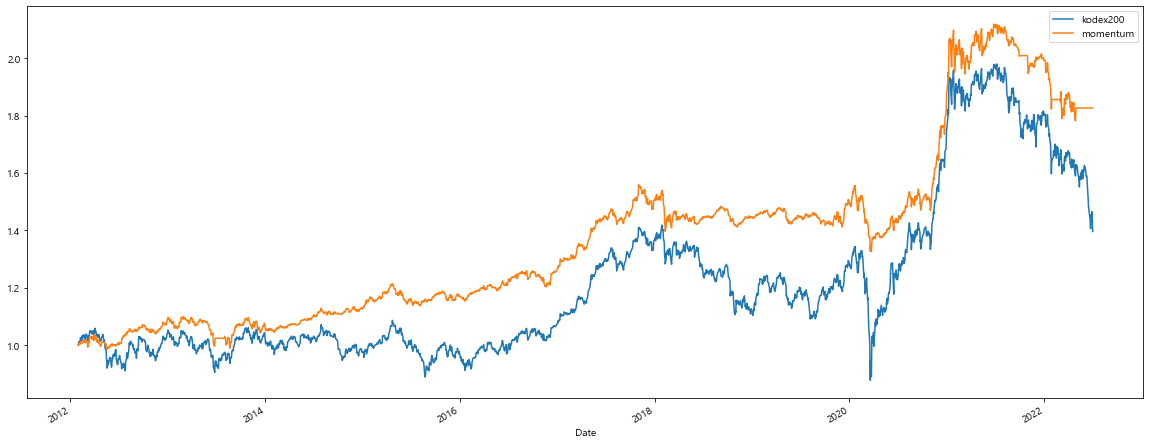

In [39]:
plt.rc('font', family='malgun gothic')
plt.figure(figsize=(20,8))

# rebalPortfolioCumulativeReturn.plot(label="1:1 리밸런싱")
# portfolioCumulativeReturn.plot(label="1:1 buy&hold")
stockCumReturn.plot(label="kodex200")
momentumPortfolioCumReturn.plot(label="momentum")
plt.legend()
plt.show()

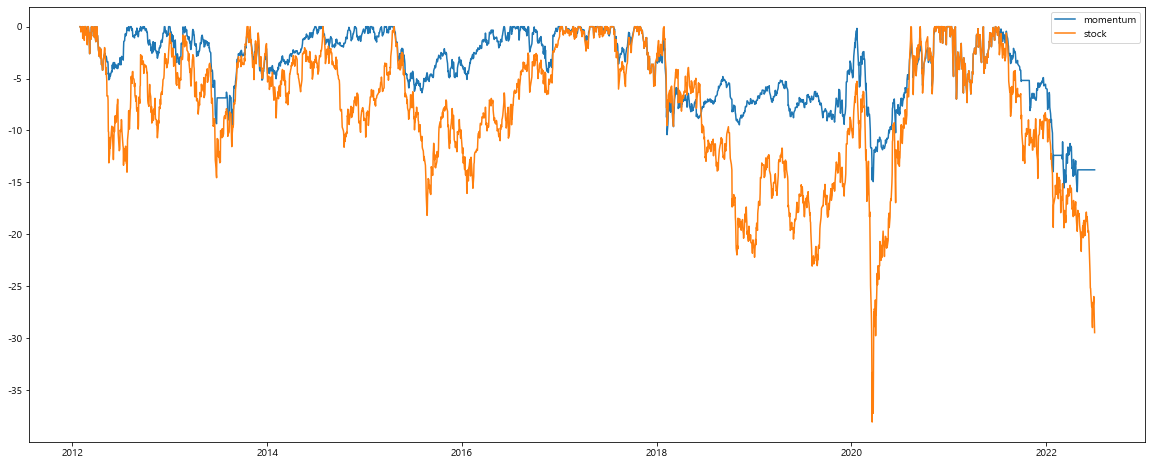

In [34]:
plt.rc('font', family='malgun gothic')
plt.rcParams['axes.unicode_minus'] = False
plt.figure(figsize=(20,8))

plt.plot(-dd , label="momentum")
plt.plot(-stockDD , label="stock")
plt.legend()
plt.show()